# Introduction to Neural Networks 
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset. 

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="images/mnist_task.png"  align="left"/>



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example 

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

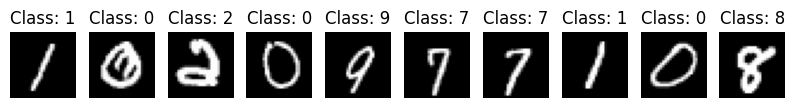

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week. 
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication. 

Note, like before, we consider multiple examples at once, adding another dimension to the input. 


 <img src="images/LinearModel_1.png"  align="center"/>
 


The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/). 

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step. 

In [6]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        
        # First, we need to convert the input image to a vector by using 
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()
        
        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes 
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)
        
    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [7]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [8]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [9]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [10]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

In [11]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5025684701601664, accuracy: 87.53125
Epoch 0: val. loss: 0.4955552042798793, val. accuracy: 87.44166666666666
Epoch 1: training loss: 0.4218597831726074, accuracy: 88.9625
Epoch 1: val. loss: 0.41305596080232176, val. accuracy: 88.79166666666667
Epoch 2: training loss: 0.3877924839258194, accuracy: 89.65833333333333
Epoch 2: val. loss: 0.3783062400018915, val. accuracy: 89.35833333333333
Epoch 3: training loss: 0.3677805757522583, accuracy: 90.10833333333333
Epoch 3: val. loss: 0.35804476351179976, val. accuracy: 89.875
Epoch 4: training loss: 0.35417453523476916, accuracy: 90.44583333333334
Epoch 4: val. loss: 0.344399760061122, val. accuracy: 90.18333333333334
CPU times: user 14min 15s, sys: 1.63 s, total: 14min 17s
Wall time: 38 s


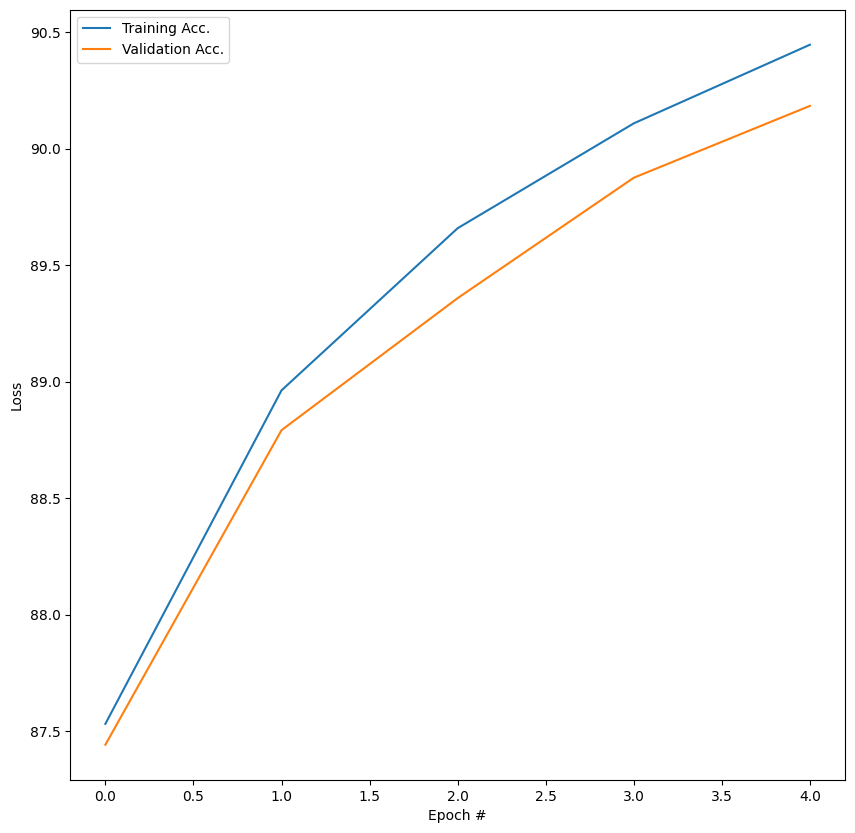

In [12]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

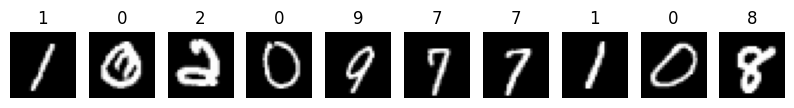

In [13]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc. 

# Prediction

Let's see how our model generalizes to the unseen test data.



In [14]:
#create dataloader for test data
# The dataloader makes our dataset iterable 
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [15]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3326, test accuracy: 90.89%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [16]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


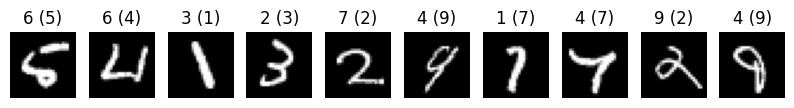

In [17]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="images/shallow_nn.png"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="images/activation.jpeg"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="images/deep_nn_annotated.jpg"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="images/bias_vs_variance.png"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="images/acc_under_over.webp"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [18]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [19]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [20]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
    
    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7099354696273804, accuracy: 79.61458333333333
Epoch 0: val. loss: 0.6985947274147196, val. accuracy: 79.63333333333334
Epoch 1: training loss: 0.4068539721171061, accuracy: 88.44999999999999
Epoch 1: val. loss: 0.39657749045402446, val. accuracy: 88.44999999999999
Epoch 2: training loss: 0.3098661961158117, accuracy: 91.04791666666667
Epoch 2: val. loss: 0.30312329451454445, val. accuracy: 90.875
Epoch 3: training loss: 0.2549116794864337, accuracy: 92.66458333333333
Epoch 3: val. loss: 0.2521933689713478, val. accuracy: 92.49166666666667
Epoch 4: training loss: 0.21829376341899237, accuracy: 93.8
Epoch 4: val. loss: 0.21668007486361138, val. accuracy: 93.59166666666667
CPU times: user 14min 47s, sys: 440 ms, total: 14min 47s
Wall time: 38.3 s


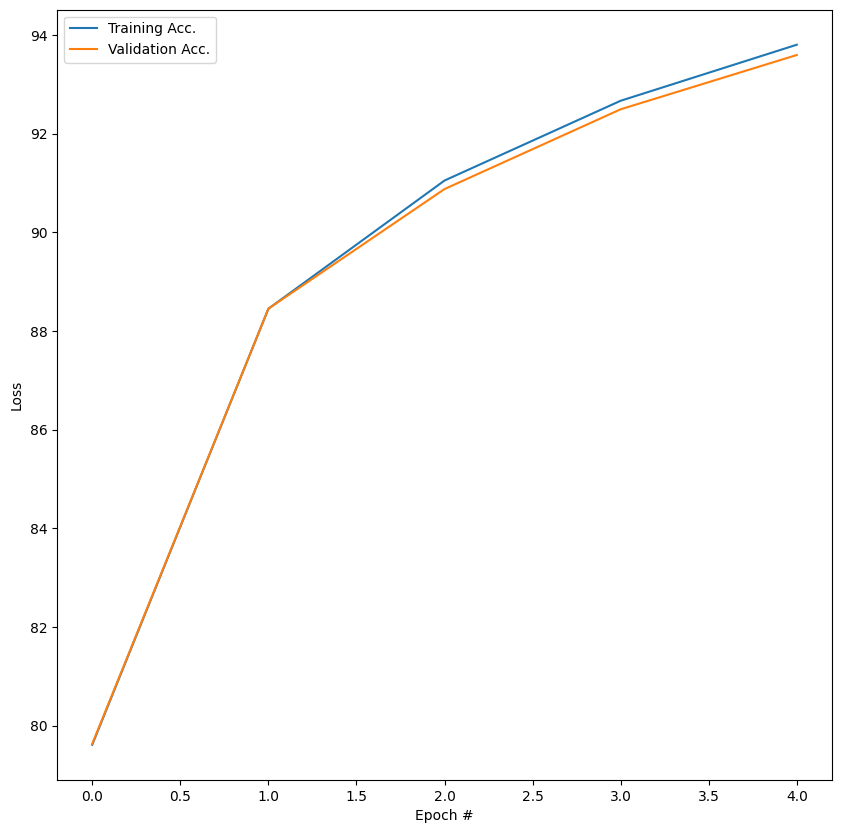

In [21]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


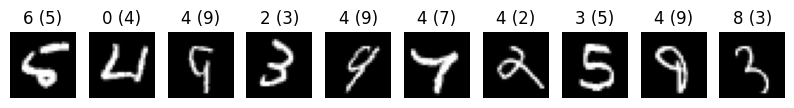

In [22]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes, 
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization. 

Epoch 0: training loss: 0.29682692846283315, accuracy: 91.27083333333333
Epoch 0: val. loss: 0.29506100705266, val. accuracy: 90.91666666666667
Epoch 1: training loss: 0.17663986248212557, accuracy: 94.63125
Epoch 1: val. loss: 0.17595460345596076, val. accuracy: 94.61666666666667
Epoch 2: training loss: 0.13845961205226678, accuracy: 95.89166666666667
Epoch 2: val. loss: 0.148336847456793, val. accuracy: 95.49166666666666
Epoch 3: training loss: 0.12127949087445934, accuracy: 96.30625
Epoch 3: val. loss: 0.1323983541385581, val. accuracy: 95.95833333333333
Epoch 4: training loss: 0.11119989852483074, accuracy: 96.5625
Epoch 4: val. loss: 0.1298789181355387, val. accuracy: 96.075


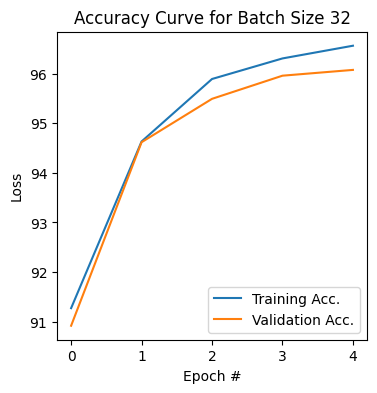

Epoch 0: training loss: 0.3880123385190964, accuracy: 88.99375
Epoch 0: val. loss: 0.3788876495462783, val. accuracy: 88.94166666666666
Epoch 1: training loss: 0.24206672991315523, accuracy: 92.91041666666666
Epoch 1: val. loss: 0.2399692278989452, val. accuracy: 92.84166666666667
Epoch 2: training loss: 0.18614656955500444, accuracy: 94.60208333333333
Epoch 2: val. loss: 0.18703608299070534, val. accuracy: 94.41666666666667
Epoch 3: training loss: 0.15681649014602106, accuracy: 95.3875
Epoch 3: val. loss: 0.1647307660648639, val. accuracy: 94.98333333333333
Epoch 4: training loss: 0.13629781544581054, accuracy: 95.98124999999999
Epoch 4: val. loss: 0.14944272929247707, val. accuracy: 95.33333333333334


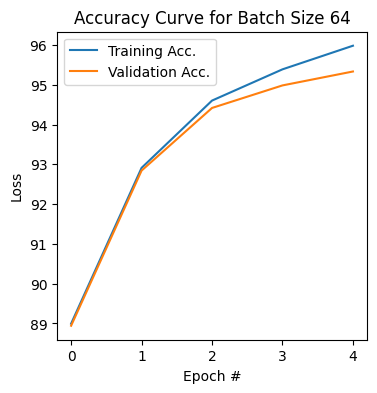

Epoch 0: training loss: 0.7426143101056417, accuracy: 77.61041666666667
Epoch 0: val. loss: 0.7369373491469849, val. accuracy: 77.2
Epoch 1: training loss: 0.3737655978600184, accuracy: 89.45833333333333
Epoch 1: val. loss: 0.3680779532866275, val. accuracy: 89.3
Epoch 2: training loss: 0.2844148513873418, accuracy: 91.9375
Epoch 2: val. loss: 0.2792860890956635, val. accuracy: 91.81666666666666
Epoch 3: training loss: 0.2313609795967738, accuracy: 93.36875
Epoch 3: val. loss: 0.2310739094589619, val. accuracy: 93.06666666666666
Epoch 4: training loss: 0.19888625846306482, accuracy: 94.14583333333333
Epoch 4: val. loss: 0.20122961874337905, val. accuracy: 93.83333333333333


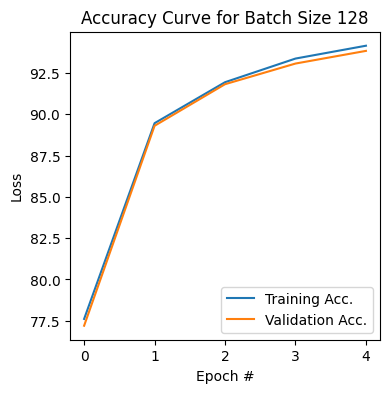

Epoch 0: training loss: 1.9719993402349187, accuracy: 39.454166666666666
Epoch 0: val. loss: 1.9711799925946174, val. accuracy: 39.475
Epoch 1: training loss: 0.849313329191918, accuracy: 75.06666666666668
Epoch 1: val. loss: 0.8469326901943126, val. accuracy: 74.24166666666666
Epoch 2: training loss: 0.4683785933129331, accuracy: 86.65416666666667
Epoch 2: val. loss: 0.4625579898661755, val. accuracy: 86.4
Epoch 3: training loss: 0.3731236105903666, accuracy: 89.275
Epoch 3: val. loss: 0.3669798602449133, val. accuracy: 89.21666666666667
Epoch 4: training loss: 0.3152135894336599, accuracy: 90.89791666666667
Epoch 4: val. loss: 0.3102904862545906, val. accuracy: 90.85833333333333


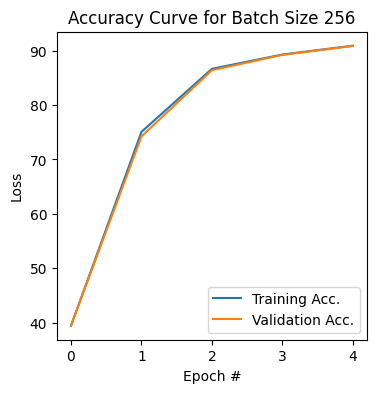

Epoch 0: training loss: 2.274594154763729, accuracy: 19.65625
Epoch 0: val. loss: 2.2738964756329856, val. accuracy: 19.866666666666667
Epoch 1: training loss: 2.063019478574712, accuracy: 39.49166666666667
Epoch 1: val. loss: 2.0615975161393485, val. accuracy: 39.733333333333334
Epoch 2: training loss: 1.2865222388125481, accuracy: 60.612500000000004
Epoch 2: val. loss: 1.2847139686346054, val. accuracy: 60.15833333333334
Epoch 3: training loss: 0.8137378648240515, accuracy: 76.75
Epoch 3: val. loss: 0.8151118333141009, val. accuracy: 76.21666666666667
Epoch 4: training loss: 0.5734038108840902, accuracy: 83.62708333333333
Epoch 4: val. loss: 0.5707333063085874, val. accuracy: 83.50833333333333


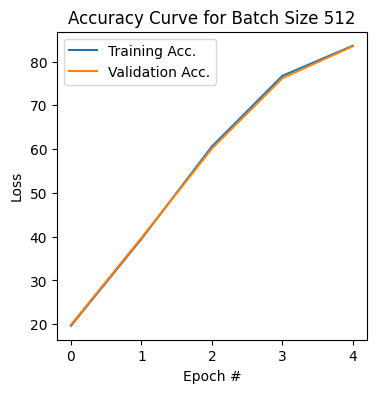

In [24]:
#First, let's compare batch sizes:

batch_sizes = [32, 64, 128, 256, 512]
def test_batch_sizes(batch_size):
    batch_size = batch_size

    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

    nonlinear_model = NonlinearClassifier()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

    epochs = 5
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
        
        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
        
        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")
    pltsize=1
    plt.figure(figsize=(4*pltsize, 4 * pltsize))
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.title(f'Accuracy Curve for Batch Size {batch_size}')
    plt.legend()
    plt.show()

for batch_size in batch_sizes:
    test_batch_sizes(batch_size)

Looking at these accuracy curves, we can see that our model tends to converge regardless of the batch size. However, one interesting phenomenon is that it appears that the model has better accuracy after 5 epochs with the lower batch sizes (96.1\% for batch size 32 vs. 83.5\% for batch size 512). This is not necessarily expected, however it could be explainable if there is not much inherent variance in the dataset. Generally, the drawback of a small batch size is that you do not have a fully accurate representation of the full dataset, so the results of your backpropagation and weight updates do not move in the direction of the true gradient. However, if each batch is a truly representative subset of the full data, a smaller batch size allows more iteration steps per epoch, which explains why we see a higher accuracy with fewer epochs.

Epoch 0: training loss: 2.3037525663375855, accuracy: 10.80625
Epoch 0: val. loss: 2.3032097385284747, val. accuracy: 10.841666666666667
Epoch 1: training loss: 2.3005942624409994, accuracy: 10.479166666666668
Epoch 1: val. loss: 2.3000405608339514, val. accuracy: 10.341666666666667
Epoch 2: training loss: 2.297067949295044, accuracy: 10.133333333333333
Epoch 2: val. loss: 2.296511510585217, val. accuracy: 10.133333333333333
Epoch 3: training loss: 2.2928707615534463, accuracy: 12.862499999999999
Epoch 3: val. loss: 2.2923206839155643, val. accuracy: 12.683333333333332
Epoch 4: training loss: 2.28763902982076, accuracy: 19.789583333333333
Epoch 4: val. loss: 2.287090651532437, val. accuracy: 19.825


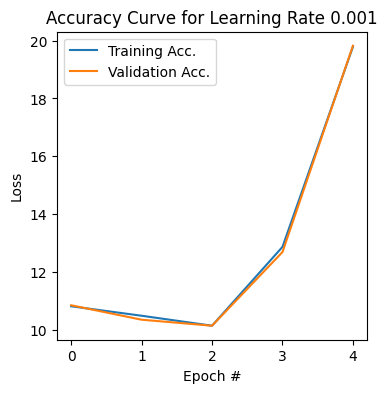

Epoch 0: training loss: 2.225178164482117, accuracy: 48.10625
Epoch 0: val. loss: 2.2241292405635753, val. accuracy: 48.40833333333333
Epoch 1: training loss: 1.101366864681244, accuracy: 70.95
Epoch 1: val. loss: 1.0919660022284121, val. accuracy: 70.55
Epoch 2: training loss: 0.5709655979077022, accuracy: 84.26041666666667
Epoch 2: val. loss: 0.5615637540183169, val. accuracy: 84.04166666666667
Epoch 3: training loss: 0.44407599107424417, accuracy: 87.77916666666667
Epoch 3: val. loss: 0.43414810965669914, val. accuracy: 87.70833333333333
Epoch 4: training loss: 0.3797038082679113, accuracy: 89.31875000000001
Epoch 4: val. loss: 0.3708520817788357, val. accuracy: 89.59166666666667


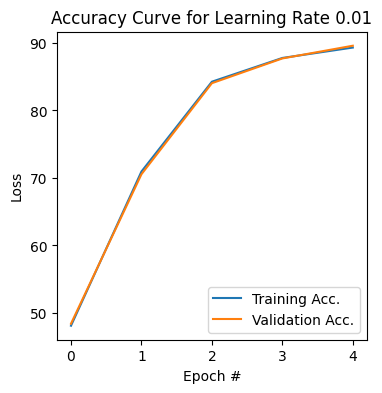

Epoch 0: training loss: 0.38442572581768036, accuracy: 88.83958333333334
Epoch 0: val. loss: 0.37481646850071054, val. accuracy: 88.86666666666667
Epoch 1: training loss: 0.25680449056625365, accuracy: 92.56458333333333
Epoch 1: val. loss: 0.25282518155476513, val. accuracy: 92.44166666666666
Epoch 2: training loss: 0.18783264455199242, accuracy: 94.49375
Epoch 2: val. loss: 0.1913709292049579, val. accuracy: 94.25
Epoch 3: training loss: 0.1550182248701652, accuracy: 95.44791666666667
Epoch 3: val. loss: 0.16242321482562322, val. accuracy: 95.08333333333333
Epoch 4: training loss: 0.13442755919943253, accuracy: 96.16666666666667
Epoch 4: val. loss: 0.14526579290271757, val. accuracy: 95.73333333333333


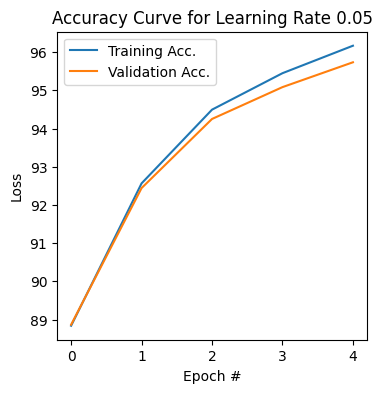

Epoch 0: training loss: 0.27170204384128255, accuracy: 92.06458333333333
Epoch 0: val. loss: 0.2651769362707087, val. accuracy: 92.225
Epoch 1: training loss: 0.17709020121147234, accuracy: 94.74583333333332
Epoch 1: val. loss: 0.1809682644447906, val. accuracy: 94.63333333333334
Epoch 2: training loss: 0.13750923981765906, accuracy: 95.89999999999999
Epoch 2: val. loss: 0.14966793330584435, val. accuracy: 95.64166666666667
Epoch 3: training loss: 0.12054761870826285, accuracy: 96.30208333333333
Epoch 3: val. loss: 0.1374432475385355, val. accuracy: 95.94166666666666
Epoch 4: training loss: 0.10849832834179203, accuracy: 96.74166666666667
Epoch 4: val. loss: 0.13105200597659705, val. accuracy: 96.15


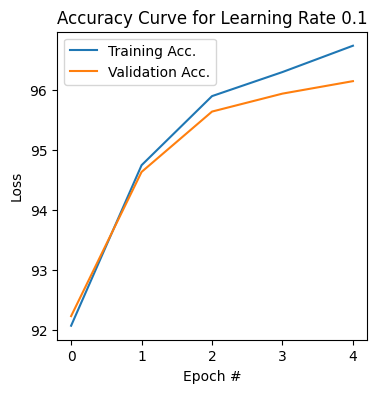

Epoch 0: training loss: 0.2284179768115282, accuracy: 93.21249999999999
Epoch 0: val. loss: 0.23373271509053858, val. accuracy: 93.06666666666666
Epoch 1: training loss: 0.1582561243971189, accuracy: 95.33125
Epoch 1: val. loss: 0.1703969271992274, val. accuracy: 94.875
Epoch 2: training loss: 0.14573969072103501, accuracy: 95.67083333333333
Epoch 2: val. loss: 0.16789591708715926, val. accuracy: 95.01666666666667
Epoch 3: training loss: 0.12972343385095397, accuracy: 96.15
Epoch 3: val. loss: 0.15113908520582667, val. accuracy: 95.55833333333334
Epoch 4: training loss: 0.13524168589090307, accuracy: 95.8875
Epoch 4: val. loss: 0.16342683174112377, val. accuracy: 95.3


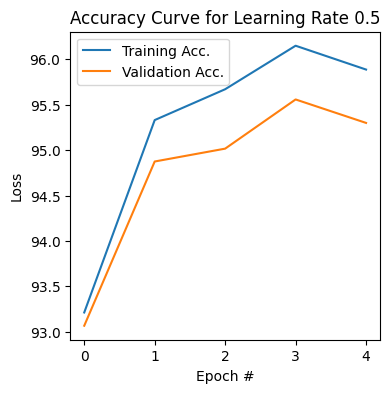

Epoch 0: training loss: 0.43429256878296535, accuracy: 89.59583333333333
Epoch 0: val. loss: 0.43022231511930203, val. accuracy: 89.5
Epoch 1: training loss: 0.30751786357164385, accuracy: 92.09791666666666
Epoch 1: val. loss: 0.31191944045589326, val. accuracy: 92.08333333333333
Epoch 2: training loss: 0.30330655817190805, accuracy: 92.05416666666667
Epoch 2: val. loss: 0.30943552202525293, val. accuracy: 92.08333333333333
Epoch 3: training loss: 0.295736483703057, accuracy: 92.86458333333333
Epoch 3: val. loss: 0.30798369451881724, val. accuracy: 92.70833333333334
Epoch 4: training loss: 0.26596677232782046, accuracy: 92.53125
Epoch 4: val. loss: 0.28018714237878933, val. accuracy: 92.31666666666666


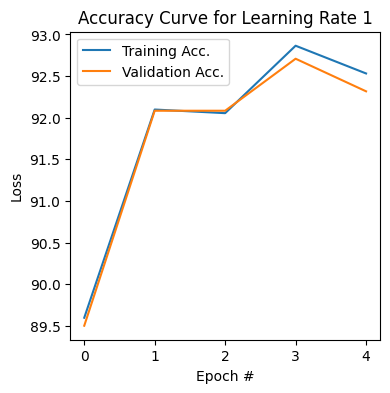

In [25]:
#Now, let's test learning rates using a similar setup:

learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5, 1]
def test_learning_rates(learning_rate):
    lr = learning_rate

    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=64)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=64)

    nonlinear_model = NonlinearClassifier()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=lr)

    epochs = 5
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
        
        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
        
        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")
    pltsize=1
    plt.figure(figsize=(4*pltsize, 4 * pltsize))
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.title(f'Accuracy Curve for Learning Rate {lr}')
    plt.legend()
    plt.show()

for lr in learning_rates:
    test_learning_rates(lr)

From these curves, we can make a few observations. If our learning rate is too small (i.e. 0.001), it will take a long time for our model to converge. If we continued to run this model for many more epochs, it will likely have similar performance to the other models, but by definition it will learn more slowly. On the other end of the spectrum, we can see that if our learning rate is too high (i.e. 1), we will fail to attain the highest possible accuracy. This is because we can't "fine-tune" our model well enough with a large learning rate, so once we reach some threshold our step size will be too large to actually navigate to the minimum of the gradient.

Epoch 0: training loss: 0.41459525062640507, accuracy: 88.16041666666666
Epoch 0: val. loss: 0.41045580225739076, val. accuracy: 87.85833333333333
Epoch 1: training loss: 0.24874842886130016, accuracy: 92.81666666666666
Epoch 1: val. loss: 0.24485385453605907, val. accuracy: 92.825
Epoch 2: training loss: 0.18491124729812145, accuracy: 94.61458333333333
Epoch 2: val. loss: 0.18553204082467772, val. accuracy: 94.375
Epoch 3: training loss: 0.15572672662635645, accuracy: 95.44583333333333
Epoch 3: val. loss: 0.16098221414227118, val. accuracy: 95.10833333333333
Epoch 4: training loss: 0.13395758134375016, accuracy: 96.03541666666666
Epoch 4: val. loss: 0.14479415205386567, val. accuracy: 95.69166666666666


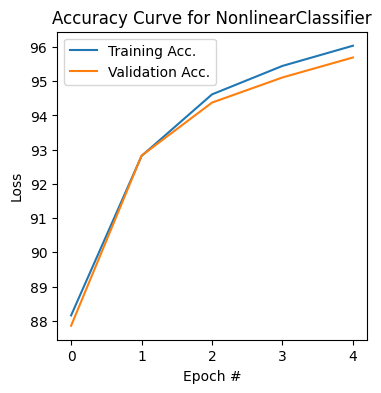

Epoch 0: training loss: 0.37676264812548954, accuracy: 89.50833333333334
Epoch 0: val. loss: 0.3694724090238835, val. accuracy: 89.45833333333333
Epoch 1: training loss: 0.2914932855467002, accuracy: 91.67291666666667
Epoch 1: val. loss: 0.28725248820921206, val. accuracy: 91.60833333333333
Epoch 2: training loss: 0.2484454605380694, accuracy: 92.8875
Epoch 2: val. loss: 0.24746165505828374, val. accuracy: 92.63333333333334
Epoch 3: training loss: 0.22003904885053635, accuracy: 93.63333333333334
Epoch 3: val. loss: 0.22078857020019216, val. accuracy: 93.375
Epoch 4: training loss: 0.19835724898676077, accuracy: 94.1375
Epoch 4: val. loss: 0.20284208435406711, val. accuracy: 93.88333333333333


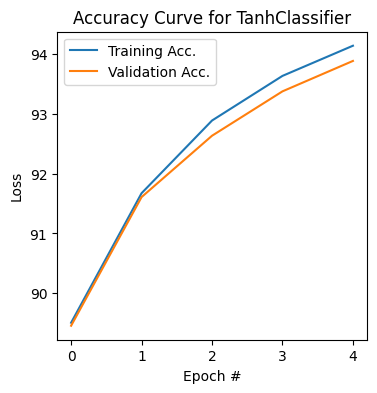

Epoch 0: training loss: 2.302804507255554, accuracy: 11.2375
Epoch 0: val. loss: 2.3029746971231826, val. accuracy: 11.233333333333333
Epoch 1: training loss: 2.302397992134094, accuracy: 11.2375
Epoch 1: val. loss: 2.3025618132124555, val. accuracy: 11.233333333333333
Epoch 2: training loss: 2.3018556248346966, accuracy: 11.2375
Epoch 2: val. loss: 2.3020115570819124, val. accuracy: 11.233333333333333
Epoch 3: training loss: 2.3010757166544598, accuracy: 11.2375
Epoch 3: val. loss: 2.301223005386109, val. accuracy: 11.233333333333333
Epoch 4: training loss: 2.2997653239568074, accuracy: 11.2375
Epoch 4: val. loss: 2.2998987778704216, val. accuracy: 11.233333333333333


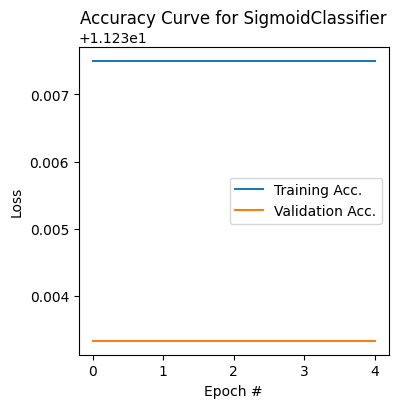

Epoch 0: training loss: 0.639268683830897, accuracy: 80.54583333333333
Epoch 0: val. loss: 0.6297148396360114, val. accuracy: 80.84166666666667
Epoch 1: training loss: 0.33928947139779725, accuracy: 89.98333333333333
Epoch 1: val. loss: 0.332434868440032, val. accuracy: 89.825
Epoch 2: training loss: 0.2564218111435572, accuracy: 92.50208333333333
Epoch 2: val. loss: 0.2523089348477252, val. accuracy: 92.18333333333332
Epoch 3: training loss: 0.21100304202735423, accuracy: 93.78958333333334
Epoch 3: val. loss: 0.2096929855327657, val. accuracy: 93.55833333333334
Epoch 4: training loss: 0.17825724072009325, accuracy: 94.68124999999999
Epoch 4: val. loss: 0.1782756105976853, val. accuracy: 94.56666666666666


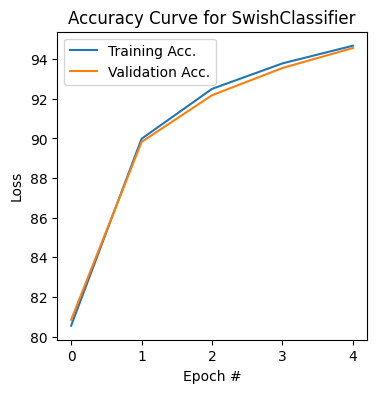

In [27]:
#Finally, let's look at activation functions by defining a few more models:

nonlinear_model = NonlinearClassifier()

class TanhClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Tanh(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

tanh_model = TanhClassifier()

class SigmoidClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Sigmoid(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

sigmoid_model = SigmoidClassifier()

class SwishClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.SiLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.SiLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.SiLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

swish_model = SwishClassifier()

#Iteratively train and evaluate models
models = [nonlinear_model, tanh_model, sigmoid_model, swish_model]
loss_fn = nn.CrossEntropyLoss()
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=64)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=64)


for model in models:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
    epochs = 5
    train_acc_all = []
    val_acc_all = []
    for j in range(epochs):
        train_one_epoch(train_dataloader, model, loss_fn, optimizer)
        
        # checking on the training loss and accuracy once per epoch
        acc, loss = evaluate(train_dataloader, model, loss_fn)
        train_acc_all.append(acc)
        print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")
        
        # checking on the validation loss and accuracy once per epoch
        val_acc, val_loss = evaluate(val_dataloader, model, loss_fn)
        val_acc_all.append(val_acc)
        print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")
    pltsize=1
    plt.figure(figsize=(4*pltsize, 4 * pltsize))
    plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
    plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.title(f'Accuracy Curve for {model.__class__.__name__}')
    plt.legend()
    plt.show()

Based on these results, it appears that all of our activation functions have similar performance with the exception of the Sigmoid activation function, which does not converge. Overall the most effective was actually our original ReLU function, followed by Swish, but there is not a large difference in performance among our top 3.

### Bonus

A learning rate scheduler is a feature that is part of many optimization algorithms. Essentially, it allows you to adjust your learning rate as training progresses rather than pre-defining a single learning rate for the entirety of training. This is incredibly useful, as we have shown that having a learning rate that is too small at the start of training may make the process take significantly longer, but having one that is too large can keep the model from reaching optimal convergence. Therefore, with a scheduler we can start training with a large learning rate to get close to our optimum, and then decrease it over time to ensure that we do not "overshoot" the optimal weight structure.

### Final Question

Unfortunately I did not have time for additional tuning, but I would guess that we can improve the performance of our model by training for more epochs (until the training and validation accuracy begin to diverge), using a learning rate scheduler as suggested above, and by increasing the number of layers in our network.